In [6]:
using DataFrames
using JSON
using Iterators
using taxis
using HDF5, JLD
using Interact
using Gadfly
using Color
using Stats
using kNN

using sequenceCompare

#reload("taxis")

nprocs()

8

In [46]:
println("Begin")

println("loading csv files")
taxi_df = readtable("/home/tony/ML/taxi/taxi2_time/train_100k.csv")
taxi_validation_df = readtable("/home/tony/ML/taxi/taxi2_time/test.csv")

println("loading coords")
taxi_df[:COORDS] = [float(hcat(JSON.parse(x)...)) for x in  taxi_df[:POLYLINE]]
taxi_validation_df[:COORDS] = [float(hcat(JSON.parse(x)...)) for x in taxi_validation_df[:POLYLINE]]

println("getting coords counts")
taxi_df[:NUM_COORDS] = [int(length(x)/2)::Int64 for x in taxi_df[:COORDS]]
taxi_validation_df[:NUM_COORDS] = [int(length(x)/2)::Int64 for x in taxi_validation_df[:COORDS]]

println("deleting unneeded data rows/columns")
delete!(taxi_validation_df, :POLYLINE)
delete!(taxi_df, :POLYLINE)

taxi_df[:START] = [x[:,1] for x in taxi_df[:COORDS]]
taxi_validation_df[:START] = [x[:,1] for x in taxi_validation_df[:COORDS]]

taxi_df[:END] = [x[:,end] for x in taxi_df[:COORDS]]
taxi_validation_df[:END] = [x[:,end] for x in taxi_validation_df[:COORDS]]

#These examples are not going to be useful!
deleterows!(taxi_df, find(taxi_df[:NUM_COORDS] .== 0))

println("done!")

Begin
loading csv files
loading coords
getting coords counts
deleting unneeded data rows/columns
done!


#Data Analysis

# Creating coord dict

In [8]:
small_taxi_df = GetTableOrderedSubset(taxi_df, 20000)
coordsDB = ConstructCoordsDatabase(small_taxi_df, 4)|

LoadError: syntax: incomplete: premature end of input
while loading In[8], in expression starting on line 2

In [1]:
coord_counts = [length(x)::Int64 for x in values(coordsDB)]
#coord_counts
describe(coord_counts)

LoadError: coordsDB not defined
while loading In[1], in expression starting on line 1

In [4]:
#all_coords_val = hcat(taxi_validation_df[:COORDS]...)
all_coords = hcat(taxi_df[:COORDS][1:700]...)'
x = all_coords[:,1]
y = all_coords[:,2]
#taxi_df[:COORDS][1:50]
Gadfly.plot(x=x, y=y)

LoadError: taxi_df not defined
while loading In[4], in expression starting on line 2

Showing arbitrary paths


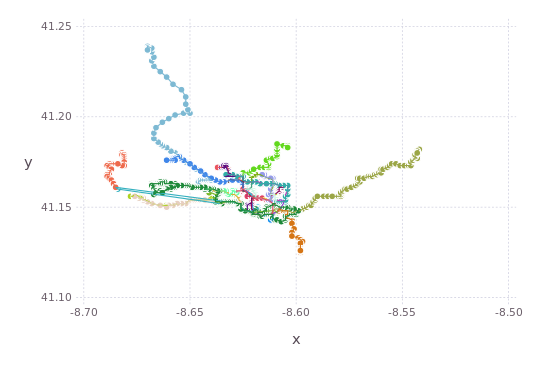

In [10]:
println("Showing arbitrary paths")

function plotCoords(coords, show_limit=40)
    num_paths = min(length(coords), show_limit)
    num_coords = length(coords)
    coordsToPlot = coords[randperm(num_coords)[1:num_paths]]
    layers = [layer(x=round(c'[:,1],3),y=round(c'[:,2],3),Geom.point, Geom.path, Theme(default_color=RGB(rand(3)...))) for c in coordsToPlot]
    Gadfly.plot(layers...) 
end

taxi_id = taxi_df[:TAXI_ID][11]
plotCoords(taxi_df[:COORDS][taxi_df[:TAXI_ID] .== taxi_id][1:30])

Plotting start and end points


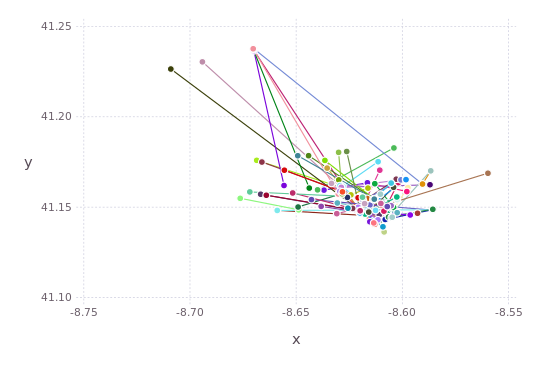

In [11]:
println("Plotting start and end points")

function plotStartAndEndPoints(coords)
    points = [[x[:,1] x[:,end]]' for x in coords]
    colors = [RGB(rand(3)...) for _ in points]
    
    layers = [layer(x=round(p[:,1],5),y=round(p[:,2],5), Geom.point, Geom.path, Theme(default_color=RGB(rand(3)...))) for p in points]
    Gadfly.plot(layers...) 
end

taxi_id = taxi_df[:TAXI_ID][11]
plotStartAndEndPoints(taxi_df[taxi_df[:TAXI_ID] .== taxi_id,:][:COORDS][100:180])


Plotting paths for driving looking at start distance
test path size: 65 partial path size: 13


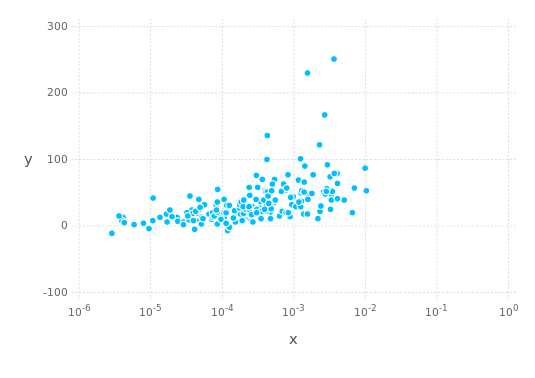

In [88]:
println("Plotting paths for driving looking at start distance")

function plotCoords(coords, show_limit=40)
    num_paths = min(length(coords), show_limit)
    num_coords = length(coords)
    coordsToPlot = coords[randperm(num_coords)[1:num_paths]]
    layers = [layer(x=round(c'[:,1],3),y=round(c'[:,2],3),Geom.point, Geom.path, Theme(default_color=RGB(rand(3)...))) for c in coordsToPlot]
    Gadfly.plot(layers...) 
end

taxi_id = taxi_df[:TAXI_ID][11]
test_path = taxi_df[taxi_df[:TAXI_ID] .== taxi_id,:][:COORDS][228]
a_taxi_df = taxi_df[taxi_df[:TAXI_ID] .== taxi_id,:][1:200,:]
println("test path size: ", size(test_path, 2), " partial path size: ", int(0.20*size(test_path,2)))
test_path = test_path[:,1:int(0.2*size(test_path,2))]

#a_taxi_df[:inv_DTW] = [float(1/sequenceCompare.DTWDistance(train_path, test_path)) for train_path in a_taxi_df[:COORDS]]
a_taxi_df[:inv_DTW] = [float(1/sequenceCompare.DTWDistance(train_path, test_path[:,1:min(end,size(train_path,2)+2)], 1)) for train_path in a_taxi_df[:COORDS]]
a_taxi_df[:NUM_COORDS_DIFF] = [float(n-size(test_path,2)) for n in a_taxi_df[:NUM_COORDS]]
a_taxi_df[:START_DIFF] = [float(euclideanDist(test_path[:,1], p)+0.000001) for p in a_taxi_df[:START]]
a_taxi_df[:START_DTW_score] = a_taxi_df[:inv_DTW] ./ a_taxi_df[:START_DIFF]
a_taxi_df[:inv_START_DTW_score] = a_taxi_df[:START_DIFF] ./ a_taxi_df[:inv_DTW]
sort!(a_taxi_df, cols=[:inv_DTW], rev=true)
p1 = Gadfly.plot(layer(x=1:398, y=a_taxi_df[:inv_DTW], Geom.point), Scale.y_log10)
p2 = Gadfly.plot(layer(x=1:398, y=a_taxi_df[:NUM_COORDS], Geom.point))
p3 = Gadfly.plot(layer(x=a_taxi_df[:inv_DTW], y=a_taxi_df[:NUM_COORDS_DIFF], Geom.point), Scale.x_log10)
p4 = Gadfly.plot(layer(x=1./a_taxi_df[:START_DIFF], y=a_taxi_df[:NUM_COORDS_DIFF], Geom.point))
p5 = Gadfly.plot(layer(x=a_taxi_df[:inv_START_DTW_score], y=a_taxi_df[:NUM_COORDS_DIFF], Geom.point), Scale.x_log10)
vstack(p5)
#a_taxi_df[:NUM_COORDS]

In [66]:
df = DataFrame(A = [1,2,3], B = [1,10,100])
df[:A] ./ df[:B]

3-element DataArray{Float64,1}:
 1.0 
 0.2 
 0.03

In [34]:
function euclideanDist(p1, p2)
    return sqrt((p1[1]-p2[1])^2 + (p1[2]-p2[2])^2)
end

s1, s2 = taxi_df[:START][13], taxi_df[:START][42]
euclideanDist(s1,s2)

0.04586648040781201

#Visualization


## Math
Grid up the map 
$ M = \left( \begin{array}{ccc}
m_{1,1} & \cdots & m_{1,n} \\
\vdots & \ddots & \vdots \\
m_{n,1} & \cdots & m_{n,n} \end{array} \right) $ \

Certain points will have a much higher "ending prior"
$ Pr(p_{i,j} = END) = $ No. of paths that end here / No. of paths that pass through here

We also could empose a markov assumption:
$ Pr(p_k = m_{i,j} | p_{k-1} = m_{i-1,j})$

This problem can be seen as a markov model then.  We could use MRF or CRF that predict vector of direction.

Could also empose start/end priors:
$ Pr(p_k = dest_j | p_0 = src_j) $

* Instead of having a list of coordinates, it may make more sense to map trips to a sequence of interest points:
Points that occur with med/high frequency.  This will remove alot of noise and simplify paths.

* Idea: use k-means on the coordinate set to find K most common points on the map $p_1 \cdots p_K$, we can re-encode each path as $c_i^* = arg\min_{k} {|p_k - c_i|}$. We could collapse sequences of repeated elements for simplicity, optionally encoding as (c_i, \# times)


__Idea__.  __find the conduits__.  The longest frequently traveled roads where most people that enter will leave.  For a new one, if we see them entering the conduit, we can be confident they will exit the conduit.

In [156]:
# deleting rows/ filtering rows from a dataframe
is_even = x -> x % 2 .== 0
df = DataFrame(A = [11,12,13,14,15], B = [1,2,3,4,5])
#deleterows!(df, find(is_even(df[:A])))
df[is_even(df[:A]),:]

,A,B
1,12,2
2,14,4


In [174]:
#deleterows!(taxi_df, find(df[:NUM_COORDS]))

taxi_df[taxi_df[:NUM_COORDS] .== 0,:]
#deleterows!(taxi_df, find(taxi_df[:NUM_COORDS] .== 0))

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,COORDS,NUM_COORDS
